In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [3]:
from dotenv import load_dotenv
load_dotenv()
import os
google_api_key = os.getenv('GOOGLE_API_KEY')
if not google_api_key: 
    raise ValueError("GOOGLE_API_KEY is not set in the environment variables.")

from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.0-flash")

In [4]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")

In [6]:
graph = graph_builder.compile()

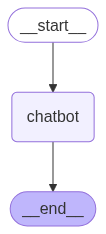

In [7]:
graph

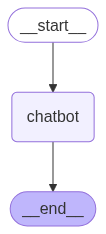

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I help you today?
Assistant: LangGraph is a Python library, built on top of LangChain, designed for creating **stateful, multi-actor applications** (often referred to as "agents") using large language models (LLMs).  Think of it as a framework for building complex, interactive conversations and workflows where different agents can collaborate and make decisions based on the current state of the interaction.

Here's a breakdown of key concepts and why it's useful:

**Core Idea: Graphs of Agents and Actions**

The fundamental concept is to represent your application as a **directed graph**.

*   **Nodes:**  Each node in the graph typically represents an *agent* or a *function*.  Agents are powered by LLMs and can perform actions (like calling tools, generating text, making decisions). Functions can be any Python code that processes data.
*   **Edges:** Edges define the *flow* of the conversation or process.  They determine how the state is updated and which node

In [11]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

/Users/libin/Code/github.com/binblee/llm-playground/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_crawl.py:80: SyntaxWarning: invalid escape sequence '\.'
  ex. "Crawl only the docs.tavily.com subdomain" ---> ["^docs\.tavily\.com$"]
/Users/libin/Code/github.com/binblee/llm-playground/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_crawl.py:99: SyntaxWarning: invalid escape sequence '\.'
  ex. "Crawl tavily.com but exclude the docs.tavily.com subdomain from the crawl" ---> ["^docs\.tavily\.com$"]
/Users/libin/Code/github.com/binblee/llm-playground/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_crawl.py:231: SyntaxWarning: invalid escape sequence '\.'
  ex. ["^docs\.example\.com$"]
/Users/libin/Code/github.com/binblee/llm-playground/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_crawl.py:241: SyntaxWarning: invalid escape sequence '\.'
  ex. [^private\.example\.com$]
/Users/libin/Code/github.com/binblee/llm-playground/.venv/lib/python3.13/s

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge(

In [12]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


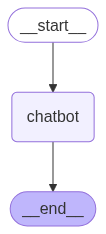

In [13]:
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)
graph

In [14]:
config = {"configurable": {"thread_id": "1"}}

In [15]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! It's nice to meet you. How can I help you today?


In [16]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, Will. I remember your name.


In [17]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name. I know you as [Your Name].


In [18]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='8020abe3-22d1-411a-9dd4-78b259e74604'), AIMessage(content="Hi Will! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f8f420c6-5793-45e0-9811-567d94dc305f-0', usage_metadata={'input_tokens': 8, 'output_tokens': 19, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='9f5fe074-0178-4e01-a854-ce1b53ba32a6'), AIMessage(content='Yes, Will. I remember your name.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--aaea3993-ce8f-

In [19]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

In [20]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [22]:
from langgraph.prebuilt import ToolNode, tools_condition
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

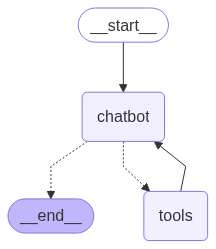

In [23]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
graph

In [24]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (3826e79b-fe28-415e-9c66-7a154cbe8518)
 Call ID: 3826e79b-fe28-415e-9c66-7a154cbe8518
  Args:
    query: I need some expert guidance for building an AI agent.


In [25]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [26]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (3826e79b-fe28-415e-9c66-7a154cbe8518)
 Call ID: 3826e79b-fe28-415e-9c66-7a154cbe8518
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend checking out LangGraph to build your agent. They say it's more reliable and extensible than simple autonomous agents.
